In [85]:
import pandas as pd
import numpy as np 
import csv
import itertools
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.tree import DecisionTreeClassifier


df_review = pd.read_csv("C:/code/dataset/rotten_tomatoes_critic_reviews.csv")
df_movie = pd.read_csv("C:/code/dataset/rotten_tomatoes_movies.csv")
df_movie.head()



,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


Content Rating Category:['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

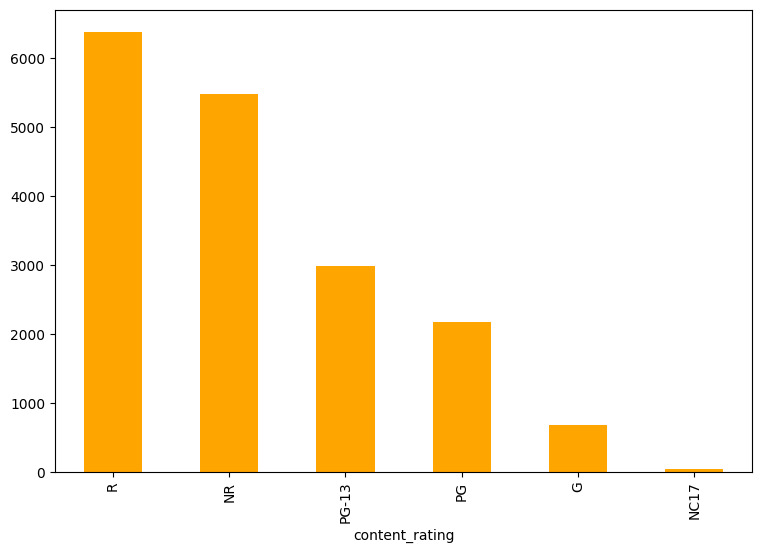

In [63]:
#Content rating visualization
print(f'Content Rating Category:{df_movie.content_rating.unique()}')
ax = df_movie.content_rating.value_counts().plot(kind ='bar', color ='orange', figsize = (9,6))
ax.bar_label(ax.containers[0], color ='white')


In [23]:
 content_rating = pd.get_dummies(df_movie.content_rating, dtype=int)


Audience status category:['Spilled' 'Upright' nan]


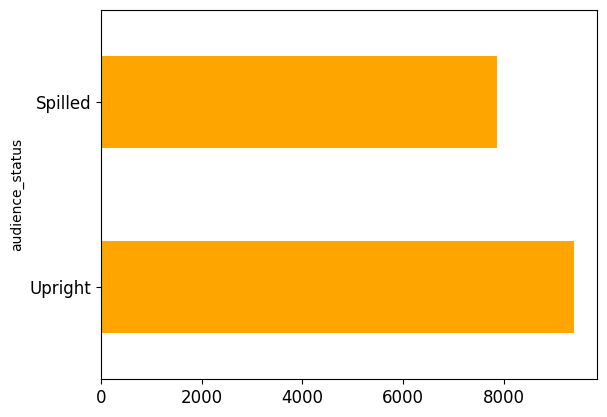

In [62]:
print(f'Audience status category:{df_movie.audience_status.unique()}')
ax = df_movie.audience_status.value_counts().plot(kind='barh',color = 'orange', fontsize=12)
plt.show()


In [26]:
#Encoding audience status variable with ordinal encoding
audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled', 'Upright'], ['0', '1']))
audience_status.head()

,audience_status
0,0
1,1
2,0
3,1
4,1


In [27]:
#Encode tomatometer status variable with ordinal encoding
tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten', 'Fresh', 'Certified-Fresh'], ['0', '1', '2']))
tomatometer_status.head()

,tomatometer_status
0,0
1,2
2,1
3,2
4,1


In [28]:
df_feature = pd.concat([df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']], content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()


,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,73,76,0,0,0,1,0,0,0,0
1,90.0,87.0,142.0,64.0,11574.0,123,19,0,0,0,0,0,1,1,2
2,122.0,67.0,24.0,53.0,14684.0,16,8,0,0,0,0,0,1,0,1
3,95.0,100.0,54.0,97.0,105386.0,54,0,0,0,1,0,0,0,1,2
4,127.0,89.0,27.0,74.0,68918.0,24,3,1,0,0,0,0,0,1,1


In [29]:
df_feature.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R
count,17017.000000,17017.000000,17017.000000,17017.000000,1.701700e+04,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000
mean,102.296233,60.519539,57.097197,60.324499,1.471183e+05,36.237292,20.871188,0.039314,0.002174,0.294940,0.124993,0.171593,0.366986
std,18.653649,28.436397,66.814580,20.480600,1.783955e+06,51.362454,29.978900,0.194346,0.046580,0.456029,0.330720,0.377037,0.481997
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,44.000000,7.410000e+02,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.000000,66.000000,29.000000,62.000000,4.423000e+03,17.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,111.000000,86.000000,76.000000,77.000000,2.606700e+04,44.000000,24.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,266.000000,100.000000,535.000000,100.000000,3.579764e+07,497.000000,303.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
len(df_feature)

17017

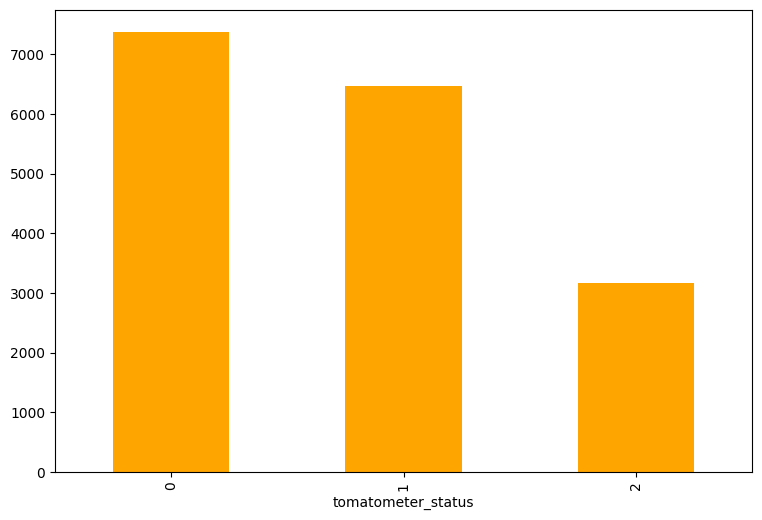

In [61]:
ax = df_feature.tomatometer_status.value_counts().plot(kind = 'bar', color = 'orange', figsize = (9,6))
ax.bar_label(ax.containers[0], color = 'white')
plt.show()

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status'], axis=1), df_feature.tomatometer_status, test_size = 0.2, random_state = 42)
print(f'Size of training data is {len(x_train)} and the size of test data is {len(x_test)}')


Size of training data is 13613 and the size of test data is 3404


In [33]:
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes =3, random_state=2)

In [34]:
tree_3_leaf.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=2)

In [35]:
y_predict = tree_3_leaf.predict(x_test)

In [36]:
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

0.9462397179788484
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       0.97      0.88      0.93      1286
           2       0.80      0.95      0.87       630

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



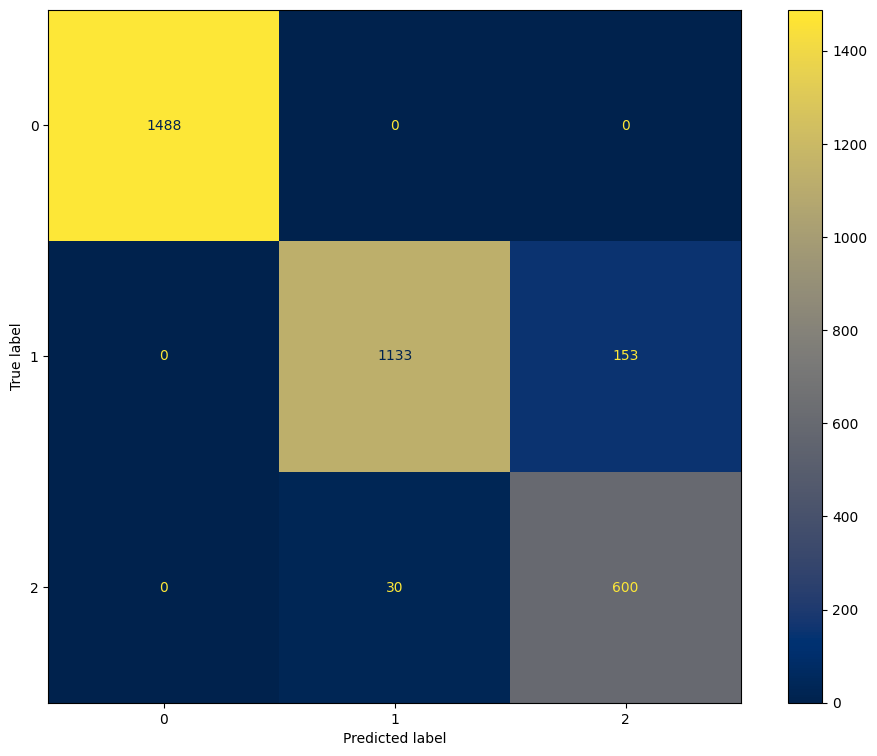

In [67]:
y_pred = tree_3_leaf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_3_leaf.classes_)
disp.plot(ax= ax, cmap='cividis')
plt.show()

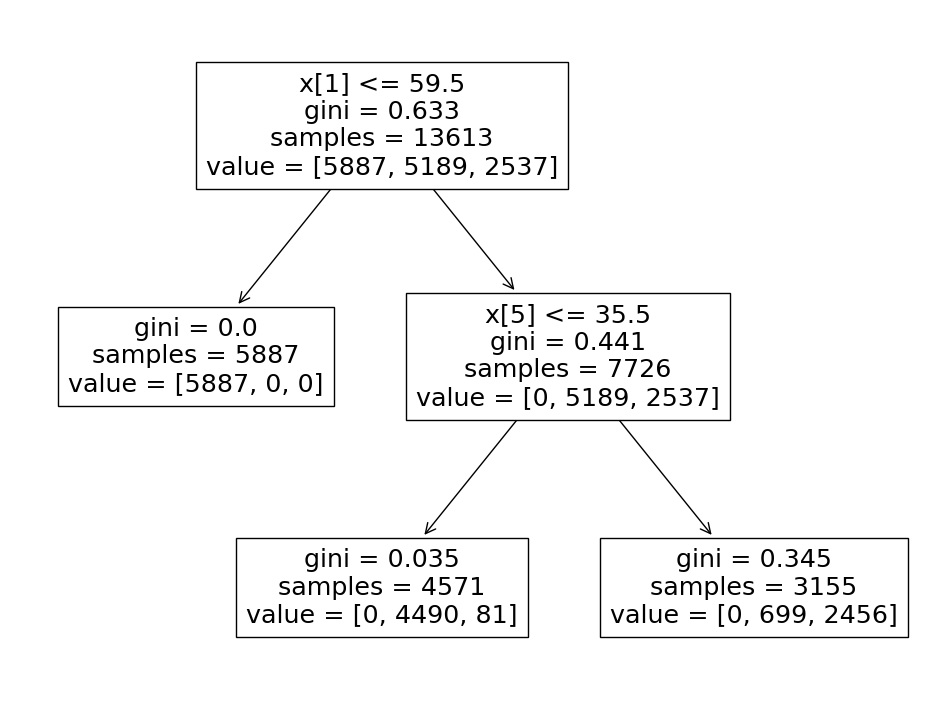

In [115]:
# the decision tree classifier stored in tree_3_leaf
fig, ax = plt.subplots(figsize=(12, 9))
tree.plot_tree(tree_3_leaf, ax=ax)
plt.show()


0.9882491186839013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       0.98      0.99      0.98      1286
           2       0.97      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.98      0.98      0.98      3404
weighted avg       0.99      0.99      0.99      3404



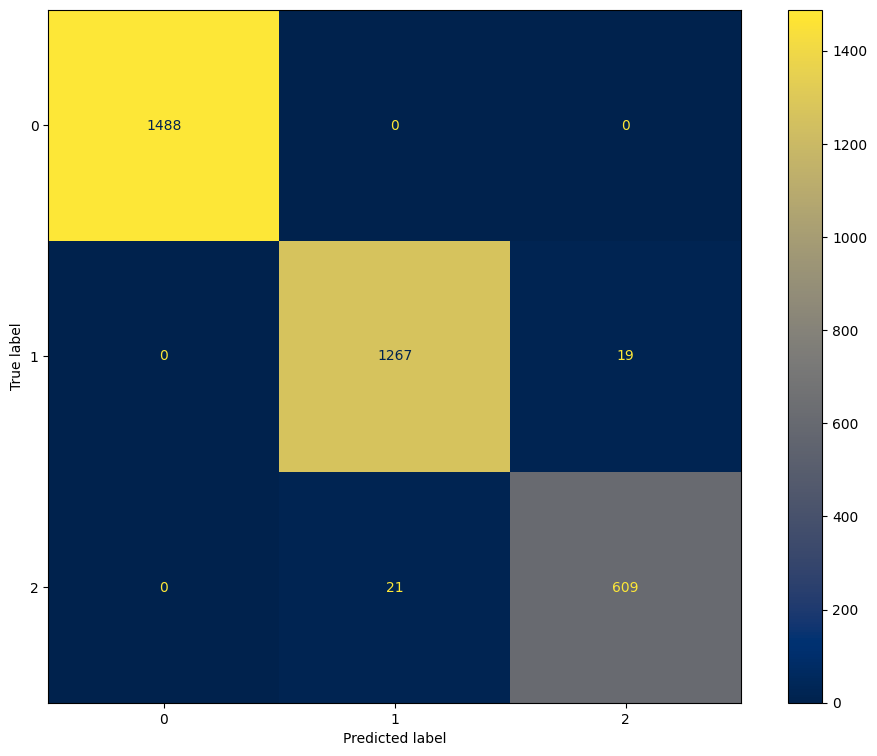

In [51]:
# Instantiate DecisionTreeClassifier with default hyperparameter settings
dt_classifier = DecisionTreeClassifier(random_state=2)

# Train the classifier on the training data
dt_classifier.fit(x_train, y_train)

# Predict the test data with the trained classifier
y_predict = dt_classifier.predict(x_test)

# Calculate accuracy and print classification report on the test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
class_labels = sorted(set(y_test) | set(y_predict))

fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap='cividis')
plt.show()



In [70]:
#Merge review dataframe and movie dataframe
df_merged = df_review.merge(df_movie, how='inner', on=['rotten_tomatoes_link'])
df_merged.head(5)
df_merged = df_merged[['rotten_tomatoes_link', 'movie_title', 'review_type', 'review_score', 'review_content', 'tomatometer_status']]
df_merged.head()

,rotten_tomatoes_link,movie_title,review_type,review_score,review_content,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Fresh,NaN,A fantasy adventure that fuses Greek mythology...,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff...",Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Fresh,NaN,With a top-notch cast and dazzling special eff...,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Fresh,3.5/5,Whether audiences will get behind The Lightnin...,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Rotten,NaN,What's really lacking in The Lightning Thief i...,Rotten


[Text(0, 0, '680954'), Text(0, 0, '383155')]

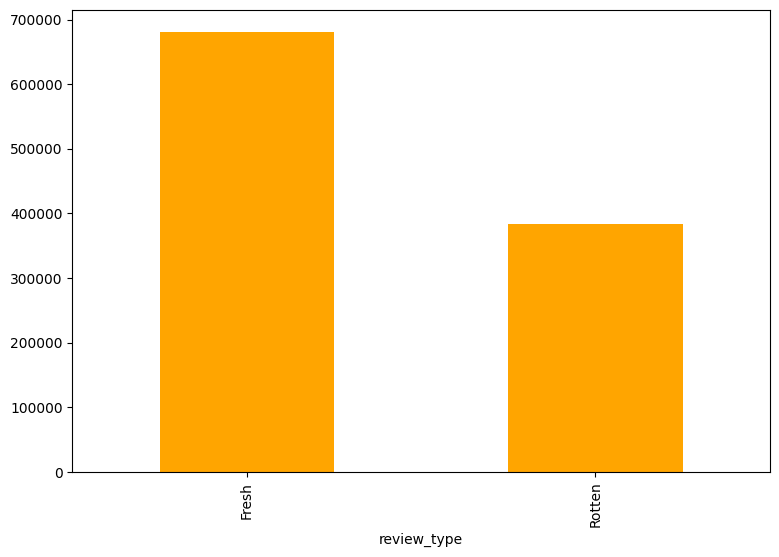

In [71]:
#Drop entries with missing reviews
df_merged = df_merged.dropna(subset=['review_content'])
#Plot distibution of the review
ax = df_merged.review_type.value_counts().plot(kind = 'bar',color ='orange' ,figsize=(9,6))
ax.bar_label(ax.containers[0], color ='white')


In [76]:
#Pick only 5000 entries from the original dataset
df_sub = df_merged[0:5000]
#Encode the label 
review_type = pd.DataFrame(df_sub.review_type.replace(['Rotten', 'Fresh'], ['0', '1']))
#Build final dataframe
df_feature_critics = pd.concat([df_sub['review_content'], review_type], axis =1).dropna()



In [77]:
#Split data into training data and testing data
x_train, x_test, y_train, y_test  = train_test_split(df_feature_critics['review_content'], df_feature_critics['review_type'], test_size=0.2, random_state = 42)
#We need to convert these strings into a format that can be used by a machine learning algorithm. This process is called tokenization in natural leanguage processing (NLP)

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       448
           1       0.72      0.72      0.72       552

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000



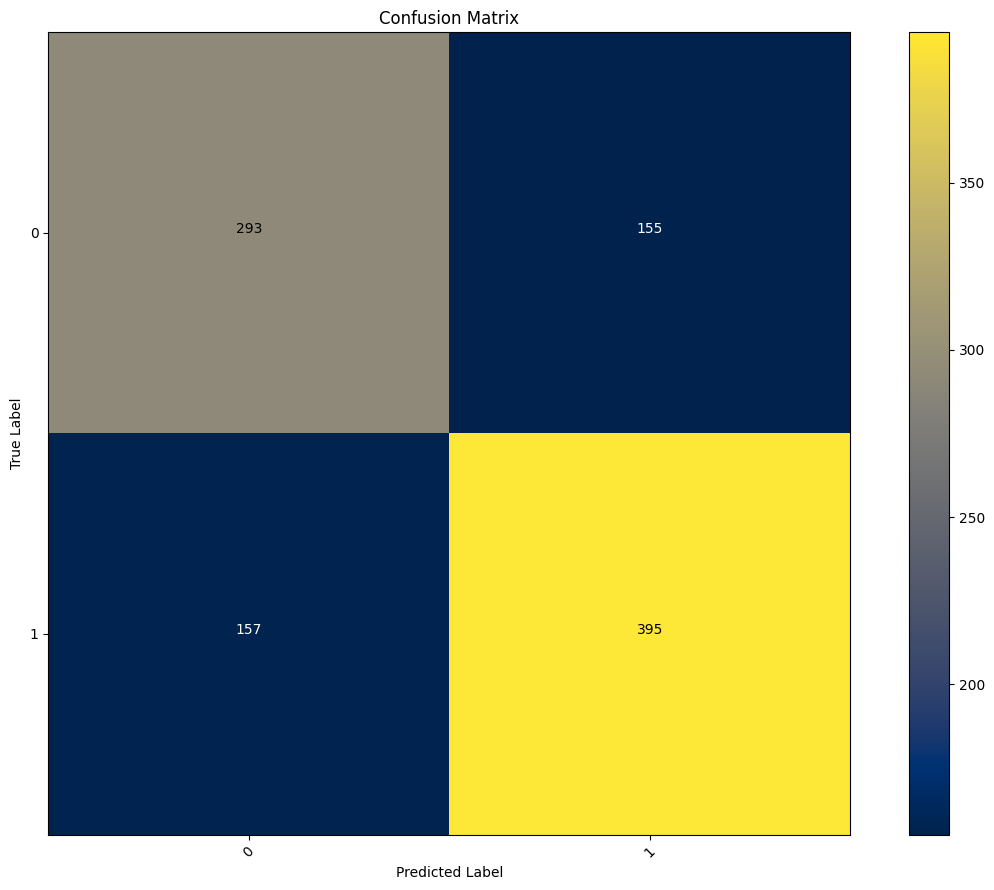

In [78]:
#Instantiatiate vectorizer class
vectorizer = CountVectorizer(min_df =1)
#Transform the text data into vector
x_train_vec = vectorizer.fit_transform(x_train).toarray()
#Initialize random forest and train it
rf = RandomForestClassifier(random_state =2)
rf.fit(x_train_vec, y_train)
#Predict and output classification report 
y_predicted = rf.predict(vectorizer.transform(x_test).toarray())

print(classification_report(y_test, y_predicted))
cm = confusion_matrix(y_test, y_predicted)

fig,ax = plt.subplots(figsize=(12,9))
im = ax.imshow(cm, interpolation='nearest', cmap='cividis')
ax.figure.colorbar(im, ax=ax)
classes = np.unique(np.concatenate((y_test, y_predicted), axis=None))


# Add labels to the plot
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black" if cm[i, j] > thresh else "white")

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [79]:
#Improve model performance by including class weights using the compute_class_weight function from scikit-learn
#Calculate class weight

class_weight = compute_class_weight(class_weight = 'balanced', classes =np.unique(df_feature_critics.review_type), y = df_feature_critics.review_type.values)
class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 1.058425063505504, 1: 0.9476876421531463}

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       448
           1       0.75      0.66      0.71       552

    accuracy                           0.69      1000
   macro avg       0.70      0.70      0.69      1000
weighted avg       0.70      0.69      0.69      1000



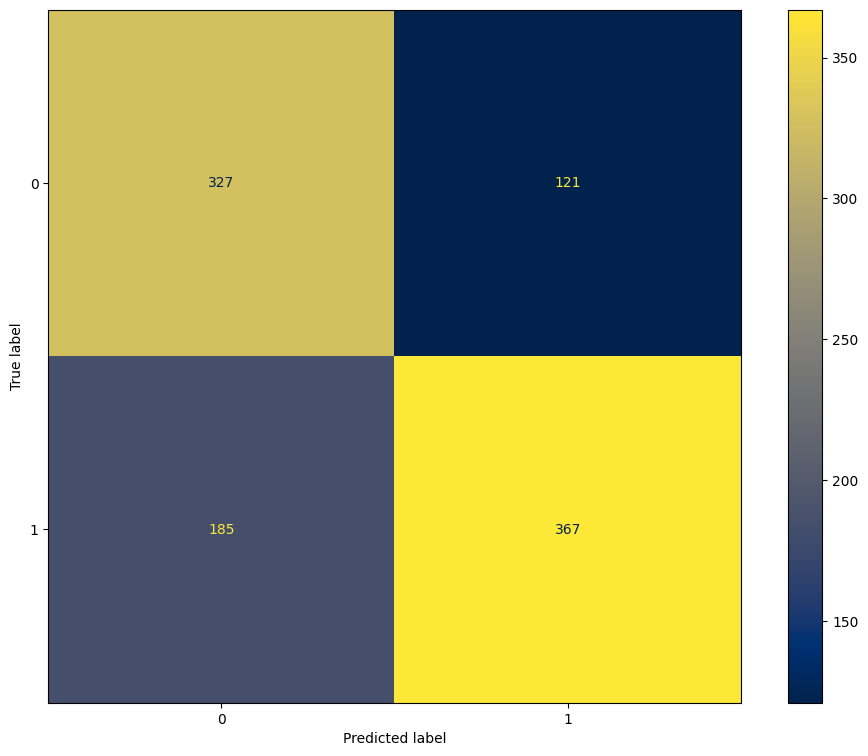

In [84]:
label_mapping = {label: i for i, label in enumerate(['0', '1'])}
y_train_int = np.array([label_mapping[label] for label in y_train])
y_test_int = np.array([label_mapping[label] for label in y_test])

# Instantiate vectorizer class
vectorizer = CountVectorizer(min_df=1)

# Transform the text data into vectors
x_train_vec = vectorizer.fit_transform(x_train).toarray()

# Get unique class labels from training data
class_labels = np.unique(y_train_int)

# Calculate class weights based on class distribution
class_counts = np.bincount(y_train_int)
total_samples = np.sum(class_counts)
class_weights = {label: total_samples / (len(class_labels) * count) for label, count in enumerate(class_counts)}

# Initialize random forest and train it
rf_weighted = RandomForestClassifier(random_state=2, class_weight=class_weights)
rf_weighted.fit(x_train_vec, y_train_int)

# Predict and output classification report
x_test_vec = vectorizer.transform(x_test).toarray()
y_predicted_int = rf_weighted.predict(x_test_vec)
y_predicted = np.array([str(label) for label in y_predicted_int])

print(classification_report(y_test, y_predicted))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_predicted)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_weighted.classes_)
disp.plot(ax=ax, cmap='cividis')
plt.show()






